## Edges

Inspect our graph and subgraphs to get a better idea of how connected our nodes are.

In [1]:
import time
import os

import numpy as np

import torch, torch_geometric.transforms as T, torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

from torch_geometric.loader import DataLoader
from torch_geometric.nn import MetaLayer
from torch_geometric.utils import subgraph

import pytorch_lightning as pl

import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    average_precision_score,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
)

from cancernet.arch import InteractionNet, VisibleGraphInteractionNet
from cancernet.util import ProgressBar, InMemoryLogger, get_roc
from cancernet import PnetDataSet, ReactomeNetwork
from cancernet.dataset import get_layer_maps

In [2]:
reactome_kws = dict(
    reactome_base_dir=os.path.join("data", "reactome"),
    relations_file_name="ReactomePathwaysRelation.txt",
    pathway_names_file_name="ReactomePathways.txt",
    pathway_genes_file_name="ReactomePathways.gmt",
)
reactome = ReactomeNetwork(reactome_kws)

prostate_root = os.path.join("data", "prostate")
dataset = PnetDataSet(
    root=prostate_root,
    name="prostate_graph_humanbase",
    edge_tol=0.5,
    pre_transform=T.Compose(
        [T.GCNNorm(add_self_loops=False), T.ToSparseTensor(remove_edge_index=False)]
    ),
)

# loads the train/valid/test split from pnet
splits_root = os.path.join(prostate_root, "splits")
dataset.split_index_by_file(
    train_fp=os.path.join(splits_root, "training_set_0.csv"),
    valid_fp=os.path.join(splits_root, "validation_set.csv"),
    test_fp=os.path.join(splits_root, "test_set.csv"),
)

In [3]:
maps = get_layer_maps(
    genes=[g for g in dataset.node_index],
    reactome=reactome,
    n_levels=2,
    direction="root_to_leaf",
    add_unk_genes=False,
    verbose=True,
)

layer # 0
pathways 146
genes 10621
filtered_map (9054, 0)
filtered_map (9054, 0)
filtered_map (9054, 0)
layer # 1
pathways 26
genes 147
filtered_map (146, 0)
filtered_map (146, 0)
filtered_map (146, 0)
layer # 2
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)


## Train

Set up hyperparameters and random seed.

In [4]:
# try to ensure reproducibility
pl.seed_everything(42, workers=True)

n_epochs = 100
batch_size = 10
lr = 0.001

Global seed set to 42


Prepare data.

In [5]:
train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.train_idx),
)
valid_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.valid_idx),
)

Create and train model.

In [6]:
# input node feature size
inputs = 3
# output dimensions of each subgraph
outputs = 1
# size of hidden layers in graphs (both MLP size and latent representation of nodes and edge)
hidden = 16
# number of graphs to stack
layers = 2

t0 = time.time()
model = VisibleGraphInteractionNet(
    pathway_maps=maps,
    node_index=dataset.node_index,
    # edge_model=edge_model, node_model=node_model, global_model=global_model,
    model_config={
        "inputs": inputs,
        "outputs": outputs,
        "hidden": hidden,
        "layers": layers,
    },
    sparse=False,
)
logger = InMemoryLogger()

# XXX this cannot be fully deterministic on GPU because
# XXX scatter_add_cuda_kernel does not have a deterministic implementation!
trainer = pl.Trainer(
    accelerator="auto",
    max_epochs=n_epochs,
    callbacks=[ProgressBar()],
    logger=logger,
    # deterministic=True,
)
trainer.fit(model, train_loader, valid_loader)
print(f"Training took {time.time() - t0:.1f} seconds.")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | subsys | ModuleList | 880 K 
1 | nn     | Sequential | 3.9 K 
--------------------------------------
884 K     Trainable params
0         Non-trainable params
884 K     Total params
3.539     Total estimated model params size (MB)
/mnt/home/ttesileanu/miniconda3/envs/cancerenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/mnt/home/ttesileanu/miniconda3/envs/cancerenv/lib/python3.9/site-packages/pytor

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training took 7084.7 seconds.


In [7]:
# get numbers of nodes and edges present in each subgraph
num_total_nodes = int(dataset.data.num_nodes / len(dataset.indices()))
num_edges = int(len(dataset.data.edge_attr) / len(dataset.indices()))
edge_indices = dataset.data.edge_index[:, 0:num_edges]

In [8]:
edge_count_full = np.zeros(num_total_nodes)
for aa in range(len(edge_indices[0])):
    ## Count how many times each node index appears as an edge connection
    edge_count_full[int(edge_indices[0][aa])] += 1
print("number of nodes with zero edges:", np.count_nonzero(edge_count_full == 0))
print("number of nodes with one edgee:", np.count_nonzero(edge_count_full == 1))
print("most edges for a single node:", np.max(edge_count_full))

number of nodes with zero edges: 6946
number of nodes with one edgee: 745
most edges for a single node: 179.0


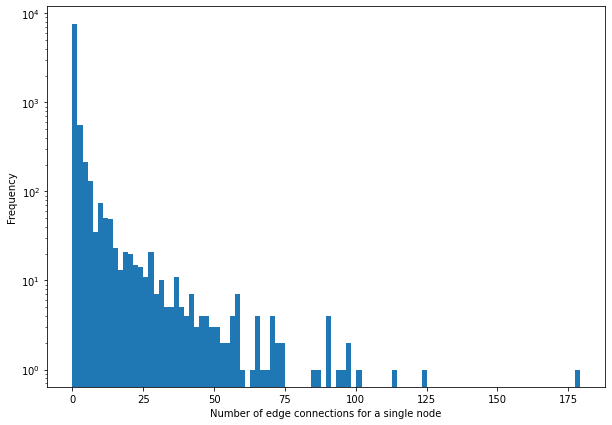

In [9]:
plt.figure(figsize=(10, 7))
plt.hist(np.array(edge_count_full), bins=100)
plt.xlabel("Number of edge connections for a single node")
plt.ylabel("Frequency")
plt.yscale("log")

In [10]:
# get numbers of nodes and edges present in each subgraph
num_nodes = maps[0].sum(axis=0).sort_values(ascending=False).to_numpy()

# indices of subgraphs, from largest to smallest
indices = np.flip(np.argsort(maps[0].sum(axis=0).to_numpy()))

# number of total edges in master graph
all_edges = int(len(dataset.data.edge_attr) / len(dataset.indices()))

edge_count = []
for index in indices:
    edge_index, edge_attr = subgraph(
        model.pathway_to_nodes[list(model.pathway_to_nodes.keys())[index]],
        edge_attr=dataset.data.edge_attr[0:num_edges],
        edge_index=dataset.data.edge_index[:, 0:num_edges],
        relabel_nodes=True,
    )
    edge_count.append(len(edge_attr))

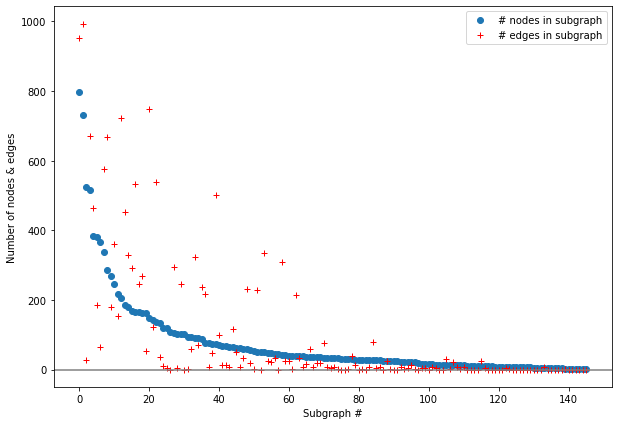

In [11]:
plt.figure(figsize=(10, 7))
plt.plot(num_nodes, "o", label="# nodes in subgraph")
plt.plot(edge_count, "+", color="red", label="# edges in subgraph")
plt.ylabel("Number of nodes & edges")
plt.xlabel("Subgraph #")
plt.axhline(0, color="gray")
plt.legend()
# plt.yscale("log")